In [60]:
# Load Library
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import sklearn
import libsvm
from libsvm.svmutil import *
import pandas as pd
import seaborn as sns

%matplotlib inline

In [61]:
# Load Data
## Load Train Data
Train = pd.read_csv("Raw/train.csv")
Train['data'] = 'train'

## Load Test Data
Test_Data = pd.read_csv("Raw/test.csv")
Test_decision = pd.read_csv("sample_submission.csv") # Put in Arbitrary Decision Value
Test = pd.concat((Test_Data, Test_decision['Decision']), axis = 1,sort=False)
Test['data'] = 'test'

## Combine Train and Test Data for Data Processing 
Data = pd.concat((Test, Train), axis = 0, ignore_index = True,sort=False)
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9911 entries, 0 to 9910
Data columns (total 23 columns):
id                        9911 non-null int64
Host_response_time        8760 non-null object
Host_is_superhost         9799 non-null object
Host_has_profile_pic      9799 non-null object
Host_identity_verified    9799 non-null object
Neighbourhood             9911 non-null int64
Property_type             9911 non-null object
Room_type                 9911 non-null object
Accommodates              9911 non-null int64
Bathrooms_text            9911 non-null object
Bedrooms                  9177 non-null float64
Beds                      9889 non-null float64
Essentials                9911 non-null int64
Cooking                   9911 non-null int64
Balcony                   9911 non-null int64
Parking                   9911 non-null int64
Price                     9911 non-null object
Number_of_reviews         9911 non-null int64
Review_scores_rating      9242 non-null float64
Insta

There are two int variables in object type(Price/Review_scores_rating). We transform them into integer. 

In [62]:
Data.head()

,id,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,...,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month,Decision,data
0,1,NaN,t,t,t,28806,Private room in bungalow,Private room,1,1 private bath,...,3,1,1,$58.00,137,4.85,f,September,0,test
1,2,within an hour,t,t,t,28805,Entire apartment,Entire home/apt,2,1 bath,...,5,1,1,$76.00,573,4.93,t,June,0,test
2,3,within an hour,t,t,t,28805,Entire rental unit,Entire home/apt,2,1 bath,...,5,1,1,$76.00,590,4.93,t,August,0,test
3,4,within an hour,t,t,t,28805,Entire rental unit,Entire home/apt,2,1 bath,...,5,1,1,$76.00,600,4.93,t,September,0,test
4,5,within an hour,t,t,t,28805,Entire apartment,Entire home/apt,2,1 bath,...,5,1,1,$76.00,581,4.93,t,July,0,test


In [63]:
Data['Price'] = Data['Price'].str.replace('$','')
Data['Price'] = Data['Price'].str.replace(',','')
Data['Price'] = pd.to_numeric(Data['Price'])

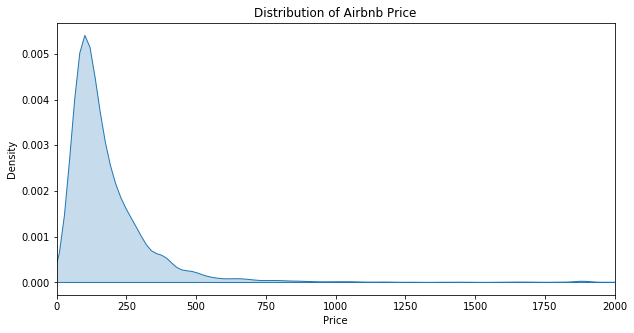

In [64]:
plt.figure(figsize=(10,5))
plt.xlim(0,2000)
plt.xlabel('Price')
plt.ylabel('Density')
sns.kdeplot(Data['Price'],shade=True)
plt.title('Distribution of Airbnb Price')
plt.show()

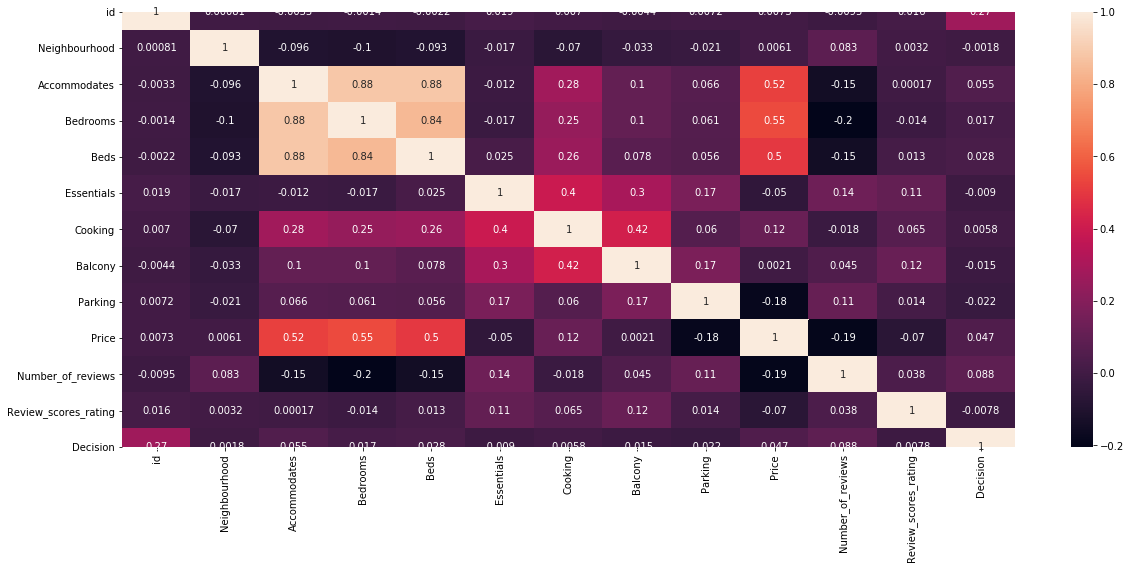

In [65]:
# Get Correlation
corr = Data.corr(method='pearson')
plt.figure(figsize=(20,8))
sns.heatmap(corr, annot=True)

In [49]:
Data = Data.drop(['Bedrooms','Beds','Bathrooms_text'], axis=1)

There are 20 variables in the training set. We can see from the heatmap above, Accommodates/Bedrooms/Beds are highly correlated with each other. We drop Bedrooms/Beds/Bathrooms_text and keep Accommodates. We then explore other categorical Data.

We have 4 binary data: 
* Host_is_superhost
* Host_identity_verified
* Instant_bookable 
Because most host has profile picture (only 13 who don't have it), we can drop 'Host_has_profile_pic'. We transform the remaining binary data to numeric value (0 represents false; 1 represents true).

<Figure size 1080x432 with 0 Axes>

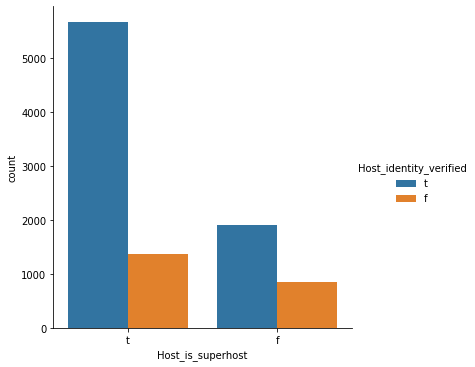

In [50]:
plt.figure(figsize=(15, 6))
sns.catplot(x='Host_is_superhost',hue='Host_identity_verified',data=Data,kind="count")

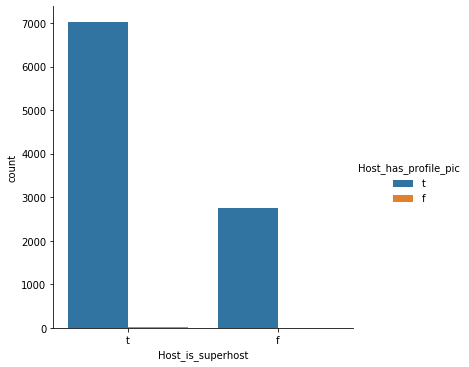

In [51]:
sns.catplot(x='Host_is_superhost',hue='Host_has_profile_pic',data=Data,kind="count")

In [52]:
Data = Data.drop(['Host_has_profile_pic'], axis=1)
Data['Host_is_superhost'] = Data['Host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
Data['Host_identity_verified'] = Data['Host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
Data['Instant_bookable'] = Data['Instant_bookable'].apply(lambda x: 1 if x == 't' else 0)

We explore the remaining categorical data:
* Host_response_time
* Neighbourhood
* Property_type
* Room_type
* Month

There are too many variables in "Property_type", which is also correlated with "Room_type". So we drop the variable Property_type. And because most valye for 'Host_response_time' is centered on 'within an hour', we drop the variable 'Host_response_time' as well. Now we left with the following categorical data:
* Neighbourhood
* Room_type
* Month

In [58]:
len(Data["Property_type"].value_counts())

58

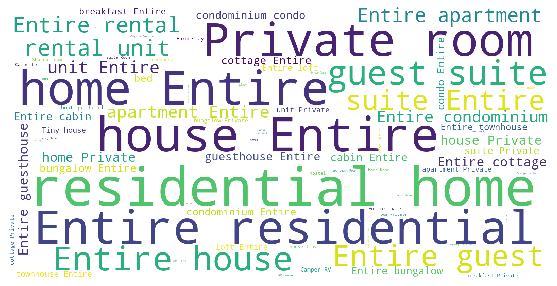

In [9]:
# pip install wordcloud
from wordcloud import WordCloud
plt.subplots(figsize=(10,5))
wordcloud = WordCloud(background_color='white',
                      width=1600, height=800
                     ).generate(" ".join(Data.Property_type))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('Property_type.png')
plt.show()

In [10]:
Data["Host_response_time"].value_counts()
Data['Neighbourhood'] = Data['Neighbourhood'].astype(str)
Data = Data.drop(['Property_type','Host_response_time','id'], axis = 1)

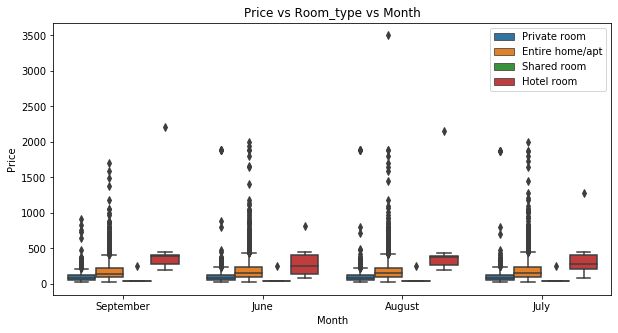

In [11]:
# Plot Price vs Room_type vs Month
plt.figure(figsize=(10, 5))
sns.boxplot(x='Month', y='Price', hue = 'Room_type', data=Data)
plt.title("Price vs Room_type vs Month")
plt.legend(loc='upper right')
plt.show()

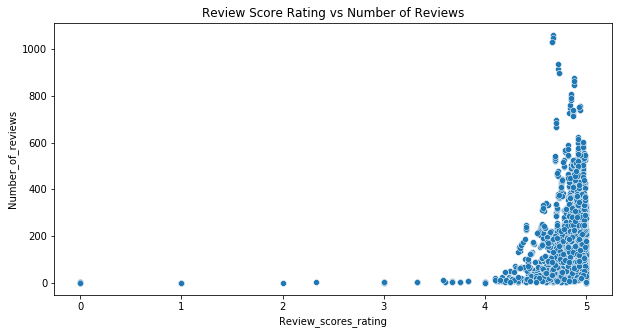

In [12]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'Review_scores_rating', y = "Number_of_reviews", data=Data)
plt.title("Review Score Rating vs Number of Reviews")
plt.show()

In [13]:
# Rreplace the 'Review_scores_rating' by zero
Data.isnull().sum()
Data.fillna({'Review_scores_rating':0}, inplace=True)

In [14]:
Data.head()

,Host_is_superhost,Host_identity_verified,Neighbourhood,Room_type,Accommodates,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month,Decision,data
0,1,1,28806,Private room,1,4,3,1,1,58.0,137,4.85,0,September,0,test
1,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,573,4.93,1,June,0,test
2,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,590,4.93,1,August,0,test
3,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,600,4.93,1,September,0,test
4,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,581,4.93,1,July,0,test


In [16]:
Train = Data[Data['data'] == 'train']
Train = Train.drop(['data'], axis = 1)
Test = Data[Data['data'] == 'test']
Test = Test.drop(['data','Decision'], axis = 1)

In [18]:
# Train.to_csv('Train.csv',index=False)
# Test.to_csv('Test.csv',index=False)